In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy.stats as st

In [ ]:
from google.colab import files

myfile = files.upload()

Saving vgames3.csv to vgames3.csv


# 개요

### "다음 분기에 어떤 게임을 설계해야 할까"

> 게임 회사의 데이터팀에서 "다음 분기에 어떤 게임을 설계해야 할까" 라는 고민을 해결하기 위해, 
> 
> 기존의 데이터에 기반하여 인사이트를 얻고, 의사결정을 하고자 하는 것이 이 프로젝트의 목표입니다.


#### 세부 프로젝트 목표:
```
- 데이터셋을 읽는 것부터, 특정 게임을 만들어야 한다는 결론 도출
- colab을 사용하여 작성
- 해당 내용을 기반으로 설명하는 영상 촬영
```
 
---
 

# 반드시 들어가야 하는 내용

> 앞서서 여러분에게 최대한의 자유를 드린다고 했지만, 그래도 발표에 반드시 포함되어야 하는 내용은 다음과 같습니다.

- 지역에 따라서 선호하는 게임 장르가 다를까 라는 질문에 대답해야 함
- 연도별 게임의 트렌드가 있을까 라는 질문에 대답해야 함
- 출고량이 높은 게임에 대한 분석 및 시각화 프로세스가 포함되어야 함


In [ ]:
import io

df = pd.read_csv(io.BytesIO(myfile['vgames3.csv']))
df.drop(columns ='Unnamed: 0', inplace=True)

df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Mark Davis Pro Bass Challenge,PS2,2002.0,Sports,Natsume,90K,0.07,0,0.02
1,King of Clubs: Mini Golf,Wii,2008.0,Sports,Oxygen Interactive,90K,0,0,0.01
2,Animal Planet: Vet Life,Wii,2009.0,Simulation,Activision,90K,0,0,0.01
3,Grand Theft Auto V,X360,2013.0,Action,Take-Two Interactive,9.63M,5.31,0.06,1.38
4,StarCraft II: Heart of the Swarm,PC,2013.0,Strategy,Activision,820K,0.65,0,190K
...,...,...,...,...,...,...,...,...,...
16593,Jikkyou Powerful Pro Yakyuu 2000 Ketteiban,PS,2000.0,Sports,Konami Digital Entertainment,0,0,0.08,0.01
16594,Namco Soccer Prime Goal,PS,1995.0,Sports,Sony Computer Entertainment,0,0,0.12,0.01
16595,White Album: Tsuzurareru Fuyu no Omoide,PS3,2010.0,Adventure,Aqua Plus,0,0,0.05,0
16596,Minna no Chizu 2,PSP,2007.0,Misc,Zenrin,0,0,0.02,0


## 데이터 전처리

In [ ]:
# 변수 선언
unit_alpha_dict = {
    'k': 1000
    , 'm': 1000000
}

In [ ]:
# pd.set_option('display.max_rows', None)

# 1. Year컬럼값에 대한 특이사항
# 1.1. 줄인년도(ex. 2013 -> 13, 1986 -> 86)
def conv_proper_year(year_val):
  if year_val <= 22:
    return year_val + 2000
  elif year_val > 22 and year_val < 100:
    return year_val + 1900
  else:
    return year_val

df['Year'] = df['Year'].apply(lambda x: conv_proper_year(x))

t = df['Year'].value_counts()
t

2009.0    1431
2008.0    1428
2010.0    1259
2007.0    1202
2011.0    1139
2006.0    1008
2005.0     941
2002.0     829
2003.0     775
2004.0     763
2012.0     657
2015.0     614
2014.0     582
2013.0     546
2001.0     482
1998.0     379
2000.0     349
2016.0     344
1999.0     338
1997.0     289
1996.0     263
1995.0     219
1994.0     121
1993.0      60
1981.0      46
1992.0      43
1991.0      41
1982.0      36
1986.0      21
1989.0      17
1983.0      17
1990.0      16
1987.0      16
1988.0      15
1985.0      14
1984.0      14
1980.0       9
2017.0       3
2020.0       1
Name: Year, dtype: int64

In [ ]:
# pd.set_option('display.max_rows', None)
# type(df['NA_Sales'].iloc[-1])
# df['NA_Sales'].value_counts()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     15864 non-null  object 
 2   Year         16327 non-null  float64
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     15866 non-null  object 
 6   EU_Sales     16598 non-null  object 
 7   JP_Sales     16598 non-null  object 
 8   Other_Sales  15060 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.1+ MB


In [ ]:
# 2. 수치형 컬럼에 대해 string -> 수치형 데이터 변환
def str_to_num(str_val):
  res_val = 0
  if pd.isna(str_val):
    # NA 또는 NULL처리(없는값)
    return res_val

  if any(c.isalpha() for c in str_val):
    # 알파벳 있음
    str_val = str_val.lower()
    for k, v in unit_alpha_dict.items():
      if not k in str_val:
        continue
      
      res_val = float(str_val.replace(k, '')) * v
  else:
    # 걍 숫자임
    res_val = float(str_val)

  return res_val

# 2.1. NA_Sales
df['NA_Sales'] = df['NA_Sales'].apply(lambda x: str_to_num(x))

# 2.2. EU_Sales
df['EU_Sales'] = df['EU_Sales'].apply(lambda x: str_to_num(x))

# 2.3. JP_Sales
df['JP_Sales'] = df['JP_Sales'].apply(lambda x: str_to_num(x))

# 2.4. Other_Sales
df['Other_Sales'] = df['Other_Sales'].apply(lambda x: str_to_num(x))

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     15864 non-null  object 
 2   Year         16327 non-null  float64
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  float64
 6   EU_Sales     16598 non-null  float64
 7   JP_Sales     16598 non-null  float64
 8   Other_Sales  16598 non-null  float64
dtypes: float64(5), object(4)
memory usage: 1.1+ MB


In [ ]:
def sum_sales(row_sr):
  return  sum([
       row_sr['NA_Sales']
       , row_sr['EU_Sales']
       , row_sr['JP_Sales']
       , row_sr['Other_Sales']
  ])

df['Total_Sales'] = df.apply(lambda x: sum_sales(x), axis=1)
df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
0,Mark Davis Pro Bass Challenge,PS2,2002.0,Sports,Natsume,90000.0,0.07,0.00,0.02,90000.09
1,King of Clubs: Mini Golf,Wii,2008.0,Sports,Oxygen Interactive,90000.0,0.00,0.00,0.01,90000.01
2,Animal Planet: Vet Life,Wii,2009.0,Simulation,Activision,90000.0,0.00,0.00,0.01,90000.01
3,Grand Theft Auto V,X360,2013.0,Action,Take-Two Interactive,9630000.0,5.31,0.06,1.38,9630006.75
4,StarCraft II: Heart of the Swarm,PC,2013.0,Strategy,Activision,820000.0,0.65,0.00,190000.00,1010000.65
...,...,...,...,...,...,...,...,...,...,...
16593,Jikkyou Powerful Pro Yakyuu 2000 Ketteiban,PS,2000.0,Sports,Konami Digital Entertainment,0.0,0.00,0.08,0.01,0.09
16594,Namco Soccer Prime Goal,PS,1995.0,Sports,Sony Computer Entertainment,0.0,0.00,0.12,0.01,0.13
16595,White Album: Tsuzurareru Fuyu no Omoide,PS3,2010.0,Adventure,Aqua Plus,0.0,0.00,0.05,0.00,0.05
16596,Minna no Chizu 2,PSP,2007.0,Misc,Zenrin,0.0,0.00,0.02,0.00,0.02


## Q1. 지역에 따라서 선호하는 게임 장르가 다를까 라는 질문에 대답해야 함

In [ ]:
q1_df = df[['Genre', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
q1_df.fillna('N/A', inplace=True)

q1_df = q1_df.groupby(by=["Genre"], dropna=False).agg(
{
    'NA_Sales': 'sum'
    , 'EU_Sales': 'sum'
    , 'JP_Sales': 'sum'
    , 'Other_Sales': 'sum'
})
q1_df

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Genre,,,,
Action,21650853.16,7160513.51,1470151.13,1340191.13
Adventure,760104.90,190063.46,80046.92,280021.58
Fighting,1360221.84,1420099.72,1340081.89,500039.94
Misc,4300403.75,2820205.02,420097.96,450081.41
N/A,5170015.44,220012.90,12.73,5.69
Platform,5220441.22,7620193.79,720128.14,590052.69
Puzzle,430122.92,410049.92,55.78,50013.77
Racing,11950345.24,2040234.56,280056.34,420075.83
Role-Playing,1600317.94,1610181.55,11750310.45,1650076.98


In [ ]:
q1_df.idxmax(axis = 0)

NA_Sales             Action
EU_Sales           Platform
JP_Sales       Role-Playing
Other_Sales    Role-Playing
dtype: object

A1:위 데이터프레임처럼, 북미는 ACTION장르, 유럽은 PLATFORM장르, 일본과 그외 지역은 ROLE-PLAYING를 선호하는 것으로 확인된다.

## Q2. 연도별 게임의 트렌드가 있을까 라는 질문에 대답해야 함

In [ ]:
# 총 출고량에서 연도별 출고량을 나누어서 한 게임이 연도별 출고량에서 차지하는 비율을 조사함.

def get_year_sales_p(_sr):
  year_total = df[(df['Year'] == _sr['Year'])]['Total_Sales'].sum()
  return _sr['Total_Sales']/year_total

df['year_sales_percent'] = df.apply(lambda x: get_year_sales_p(x), axis=1)

q2_df = df[[
            'Year', 'Genre'
# , 'Total_Sales'
, 'year_sales_percent'
]]
q2_df = q2_df[(q2_df['Year'].notna())]

q2_df = q2_df.groupby(by=["Year", "Genre"], dropna=True).agg(
{
    'year_sales_percent': 'sum'
})

q2_df = q2_df.reset_index()
q2_df


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


,Year,Genre,year_sales_percent
0,1980.0,Action,2.987698e-02
1,1980.0,Fighting,6.766257e-02
2,1980.0,Misc,2.372583e-01
3,1980.0,Shooter,6.212654e-01
4,1981.0,Action,9.998102e-01
...,...,...,...
383,2016.0,Sports,1.609214e-01
384,2016.0,Strategy,2.988387e-07
385,2017.0,Action,2.000000e-01
386,2017.0,Role-Playing,8.000000e-01


In [ ]:
q2_df2 = df[['Year', 'Genre', 'Total_Sales', 'year_sales_percent']]
q2_df2 = q2_df2[(q2_df2['Year'].notna())]
q2_df2['Year'] = q2_df2['Year'].astype('int32')

q2_df = pd.get_dummies(q2_df)

q2_df_lst = []
for i, sr in q2_df.iterrows():
  trg_col_nm = sr[sr == 1].index[0]
  # print(trg_col_nm)
  sr[trg_col_nm] = sr[trg_col_nm] * sr['year_sales_percent']
  trg_sr = sr[~sr.index.isin(['year_sales_percent'])]
  
  q2_df_lst.append(trg_sr.to_dict())
  
q2_df = pd.DataFrame(q2_df_lst)

q2_df['Year'] = q2_df['Year'].astype('int32')
                                                
q2_df_agg_dict = {col_nm: 'sum' for col_nm in q2_df.columns[~q2_df.columns.isin(['Year'])]}

q2_df = q2_df.groupby(by=["Year"], dropna=True).agg(q2_df_agg_dict)
q2_df.columns = q2_df.columns.str.lstrip("Genre_")

q2_df

,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
Year,,,,,,,,,,,,
1980,0.029877,0.000000e+00,6.766257e-02,2.372583e-01,0.000000,0.000000e+00,0.000000e+00,0.000000,6.212654e-01,0.000000e+00,0.000000,0.000000e+00
1981,0.999810,0.000000e+00,0.000000e+00,0.000000e+00,0.000063,2.044793e-05,4.362226e-06,0.000000,9.106146e-05,3.998707e-06,0.000007,0.000000e+00
1982,0.225069,0.000000e+00,0.000000e+00,3.012465e-02,0.174169,3.476454e-01,5.436288e-02,0.000000,1.319252e-01,0.000000e+00,0.036704,0.000000e+00
1983,0.170238,2.380952e-02,0.000000e+00,1.273810e-01,0.412500,4.642857e-02,0.000000e+00,0.000000,2.916667e-02,0.000000e+00,0.190476,0.000000e+00
1984,0.036743,0.000000e+00,0.000000e+00,2.879841e-02,0.013704,6.236346e-02,1.181728e-01,0.000000,6.176763e-01,0.000000e+00,0.122542,0.000000e+00
1985,0.000008,0.000000e+00,2.282343e-06,0.000000e+00,0.999977,6.977450e-06,0.000000e+00,0.000000,2.173660e-06,6.520981e-08,0.000004,0.000000e+00
1986,0.370550,0.000000e+00,0.000000e+00,0.000000e+00,0.253236,0.000000e+00,5.285868e-02,0.067961,1.049083e-01,0.000000e+00,0.150485,0.000000e+00
1987,0.051152,2.018433e-01,2.497696e-01,0.000000e+00,0.080184,0.000000e+00,0.000000e+00,0.214286,3.179724e-02,0.000000e+00,0.170968,0.000000e+00
1988,0.000009,0.000000e+00,0.000000e+00,0.000000e+00,0.999898,2.936116e-05,1.126037e-05,0.000031,2.683547e-06,1.052371e-07,0.000019,0.000000e+00


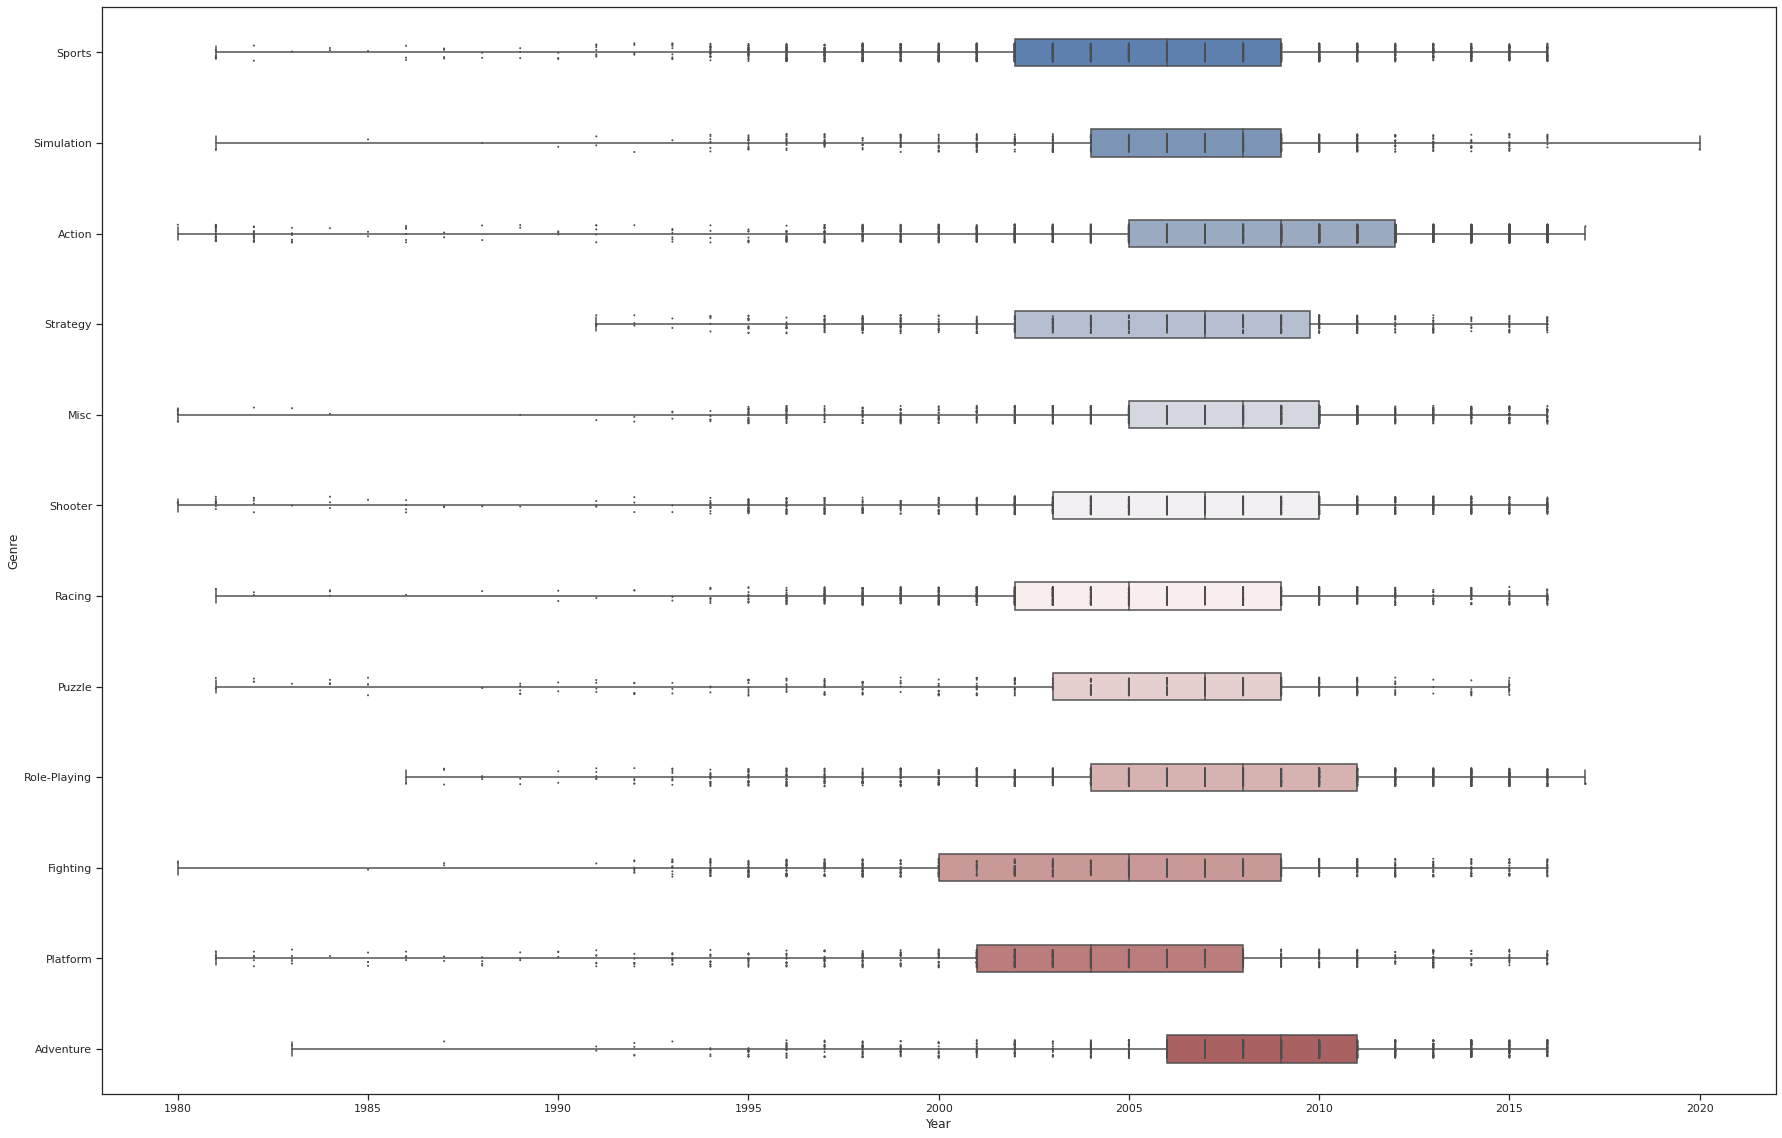

In [ ]:
import seaborn as sns

sns.set_theme(style='ticks')

f, ax = plt.subplots(figsize=(30, 20))

# ax.set_xscale('log')

sns.boxplot(
    x='Year', y='Genre', data=q2_df2
    , whis=[0, 100], width=.3, palette="vlag"
)

sns.stripplot(
    x='Year', y='Genre', data=q2_df2
    , size=2, color=".3", linewidth=0
)

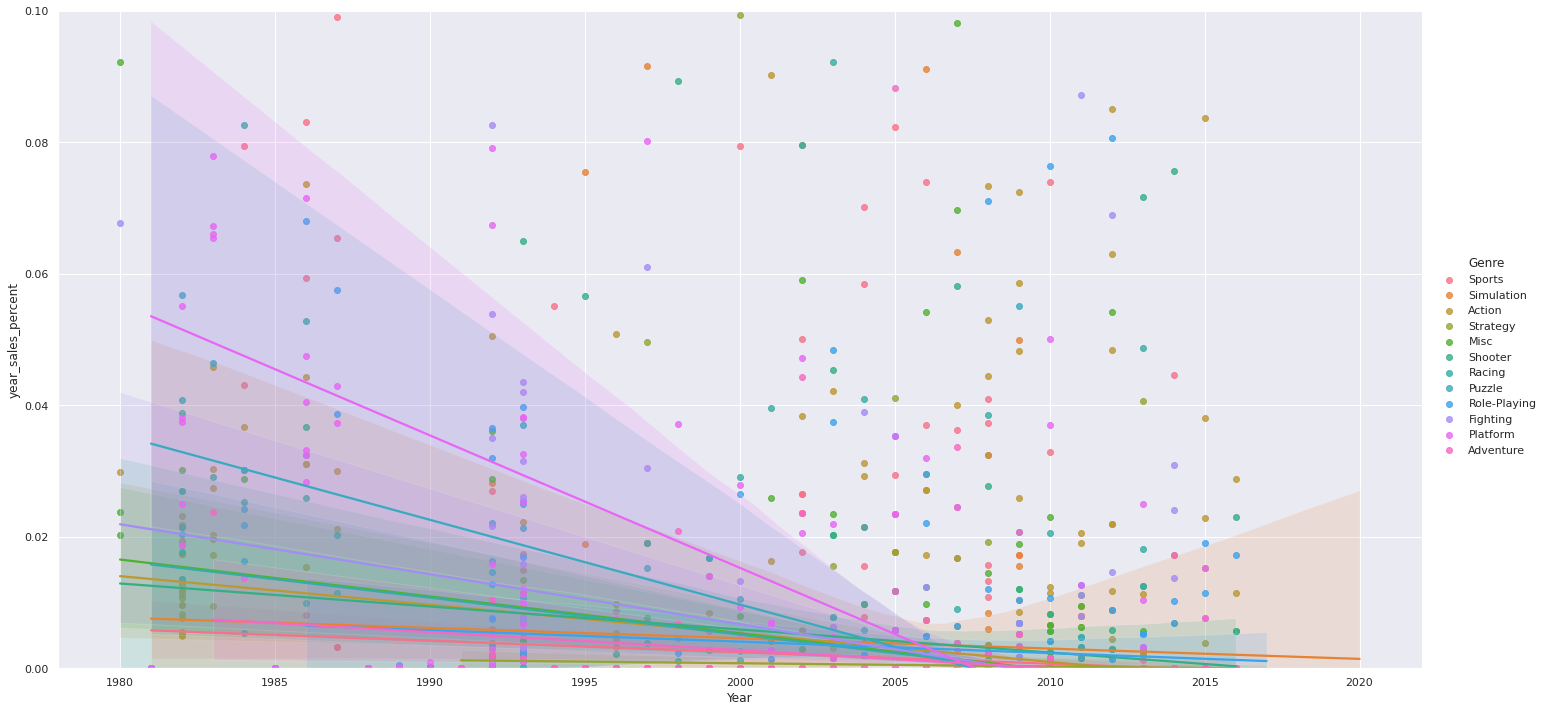

In [ ]:
g = sns.lmplot(
    data=df[['Year', 'year_sales_percent', 'Genre']],
    x="Year", y="year_sales_percent", hue="Genre"
    , height=10
    , aspect=2
)

g.set(ylim=(0, 0.1))

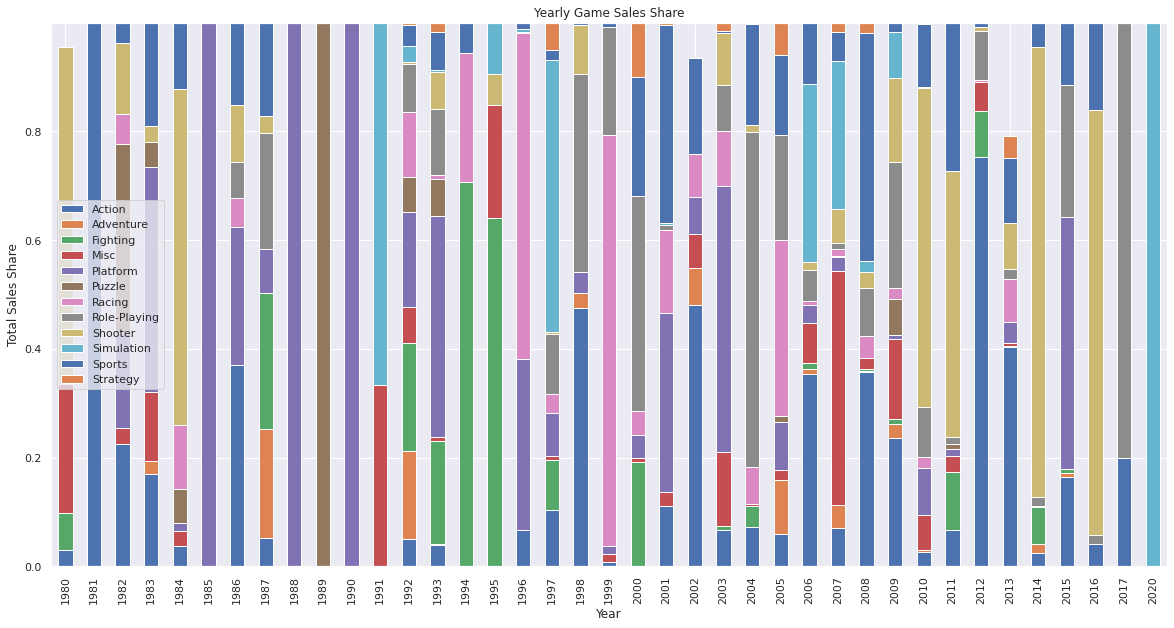

In [ ]:
# create stacked bar chart for students DataFrame
q2_df.plot(kind='bar', stacked=True, figsize=(20,10))
 
# Add Title and Labels
plt.title('Yearly Game Sales Share')
plt.xlabel('Year')
plt.ylabel('Total Sales Share')

plt.show()

A2:위 그래프처럼, 연도별 게임 트렌드...

*   레이싱게임은 1991년부터 1996년에 점진적으로 증가해 1999년 최고치에 달하고 다시 점차 감소하는 모습을 볼 수 있습니다.
*   격투게임은 1987년 갑작스럽게 높은 점유율을 차지하며 1994~1995년 최고치에 달한후 점차 감소하는 모습을 볼 수 있습니다.
*  
 2010년대 이후 들어서 슈팅게임이 강세를 보이므로 트렌드를 주도했던 것을 확인할 수 있었습니다. 
*   1990년대 후반부터 2000년대 중반까지 높은 판매량을 보인 롤플레잉 게임이 2017년에 스포츠게임과 다시 한번 시장을 주도했다는 것 역시 참고할 부분인 것 같습니다. 
*   게임이 공식적으로 출고한 이후 지금까지 스포츠장르의 게임은 지속적으로 소비자들의 사랑을 받아왔음을 알 수 있었습니다. 
*   2020년에는 잠시 뒤 확인할 데이터를 통해서도 보시겠지만 닌텐도 회사 제품의 시뮬레이션 게임이 강세를 보인 점 역시 확인할 수 있었습니다.

## Q3. 출고량이 높은 게임에 대한 분석 및 시각화 프로세스가 포함되어야 함

### 3.1. Plaform 관점

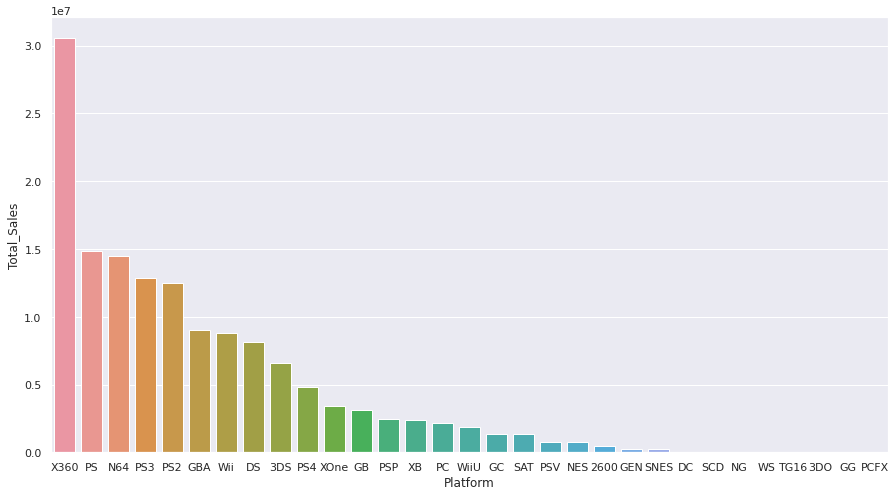

In [ ]:
q3_df1 = df[['Platform', 'Total_Sales']].groupby(by=["Platform"], dropna=True).agg(
{
    'Total_Sales': 'sum'
})
q3_df1.reset_index(inplace=True)
q3_df1.sort_values(by='Total_Sales', ascending=False, inplace=True)

sns.set(rc = {'figure.figsize':(15,8)})

g = sns.barplot(
    x="Platform", y="Total_Sales", data=q3_df1
)

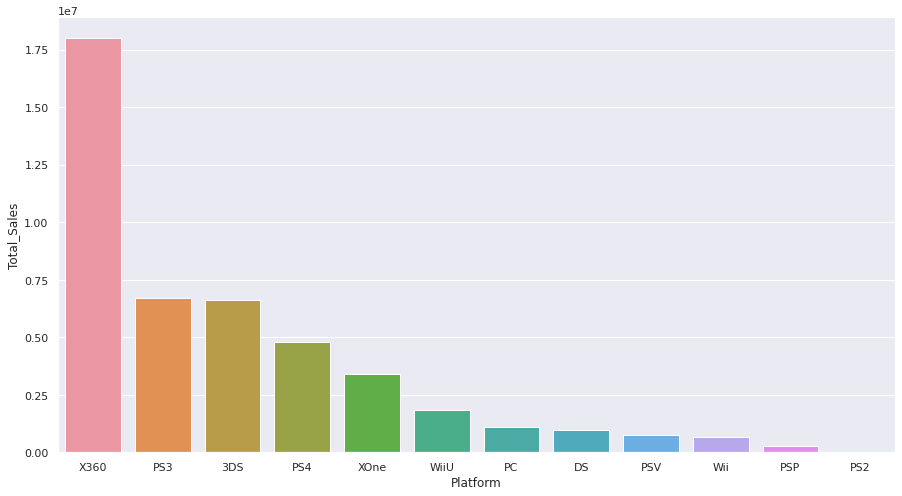

In [ ]:
q3_df1 = df[(df['Year'] > 2010)]

q3_df1 = q3_df1[['Platform', 'Total_Sales']].groupby(by=["Platform"], dropna=True).agg(
{
    'Total_Sales': 'sum'
})
q3_df1.reset_index(inplace=True)
q3_df1.sort_values(by='Total_Sales', ascending=False, inplace=True)

sns.set(rc = {'figure.figsize':(15,8)})

g = sns.barplot(
    x="Platform", y="Total_Sales", data=q3_df1
)

### 3.2. Genre 관점

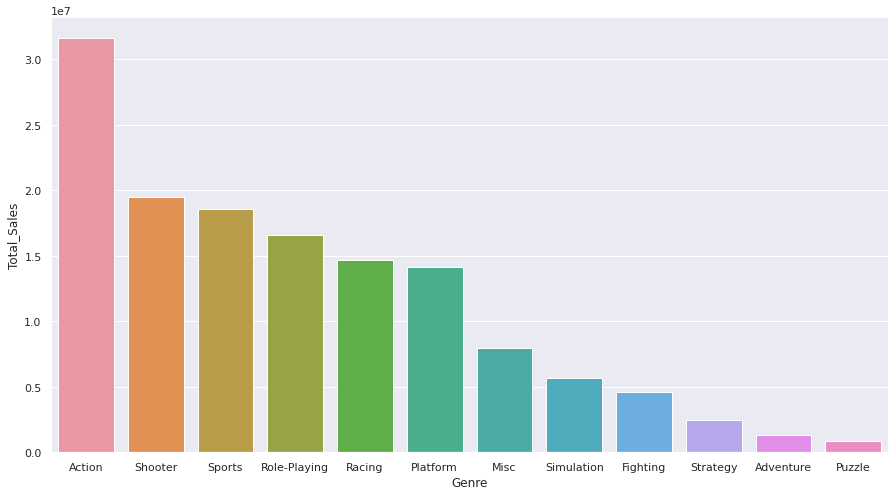

In [ ]:
q3_df2 = df[['Genre', 'Total_Sales']].groupby(by=["Genre"], dropna=True).agg(
{
    'Total_Sales': 'sum'
})
q3_df2.reset_index(inplace=True)
q3_df2.sort_values(by='Total_Sales', ascending=False, inplace=True)

sns.set(rc = {'figure.figsize':(15,8)})

g = sns.barplot(
    x="Genre", y="Total_Sales", data=q3_df2
)

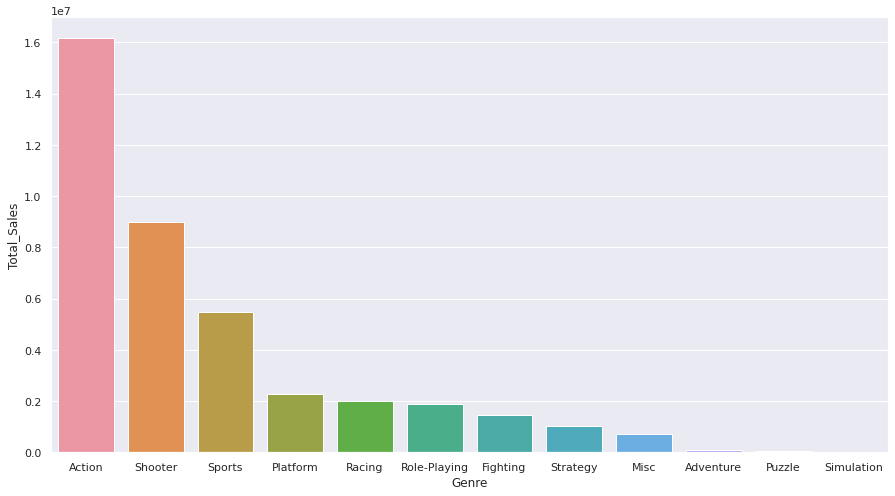

In [ ]:
q3_df2 = df[(df['Year'] > 2010)]

q3_df2 = q3_df2[['Genre', 'Total_Sales']].groupby(by=["Genre"], dropna=True).agg(
{
    'Total_Sales': 'sum'
})
q3_df2.reset_index(inplace=True)
q3_df2.sort_values(by='Total_Sales', ascending=False, inplace=True)

sns.set(rc = {'figure.figsize':(15,8)})

g = sns.barplot(
    x="Genre", y="Total_Sales", data=q3_df2
)

### 3.3. Publisher 관점

[Text(0, 0, 'Nintendo'),
 Text(0, 0, 'Electronic Arts'),
 Text(0, 0, 'Take-Two Interactive'),
 Text(0, 0, 'Activision'),
 Text(0, 0, 'Microsoft Game Studios'),
 Text(0, 0, 'Sony Computer Entertainment'),
 Text(0, 0, 'Ubisoft'),
 Text(0, 0, 'Sega'),
 Text(0, 0, 'THQ'),
 Text(0, 0, 'SquareSoft')]

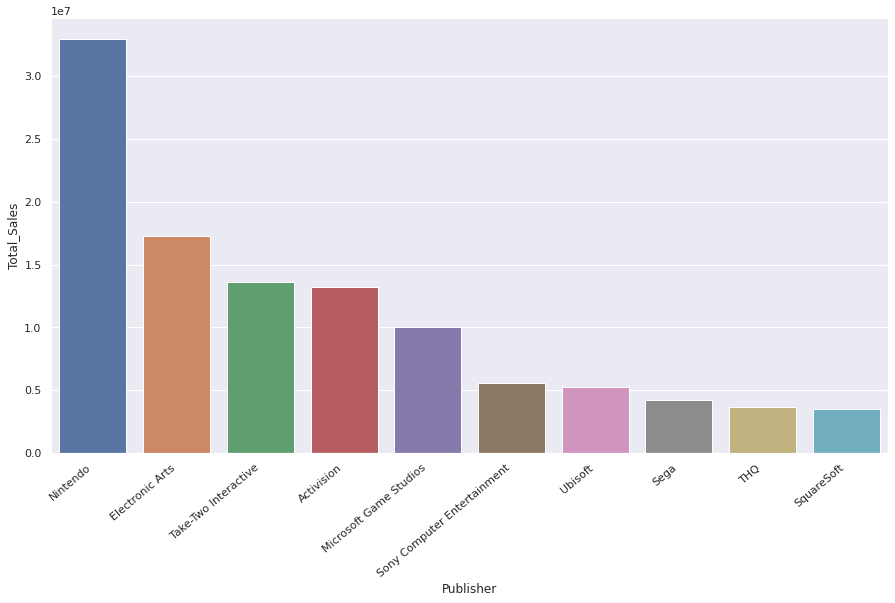

In [ ]:
q3_df3 = df[['Publisher', 'Total_Sales']].groupby(by=["Publisher"], dropna=True).agg(
{
    'Total_Sales': 'sum'
})
q3_df3.reset_index(inplace=True)
q3_df3.sort_values(by='Total_Sales', ascending=False, inplace=True)

q3_df3 = q3_df3.iloc[:10]

g = sns.barplot(
    x="Publisher", y="Total_Sales", data=q3_df3
)

g.set_xticklabels(g.get_xticklabels(), rotation=40, ha="right")

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


[Text(0, 0, 'Take-Two Interactive'),
 Text(0, 0, 'Nintendo'),
 Text(0, 0, 'Electronic Arts'),
 Text(0, 0, 'Ubisoft'),
 Text(0, 0, 'Activision'),
 Text(0, 0, 'Sony Computer Entertainment'),
 Text(0, 0, 'Microsoft Game Studios')]

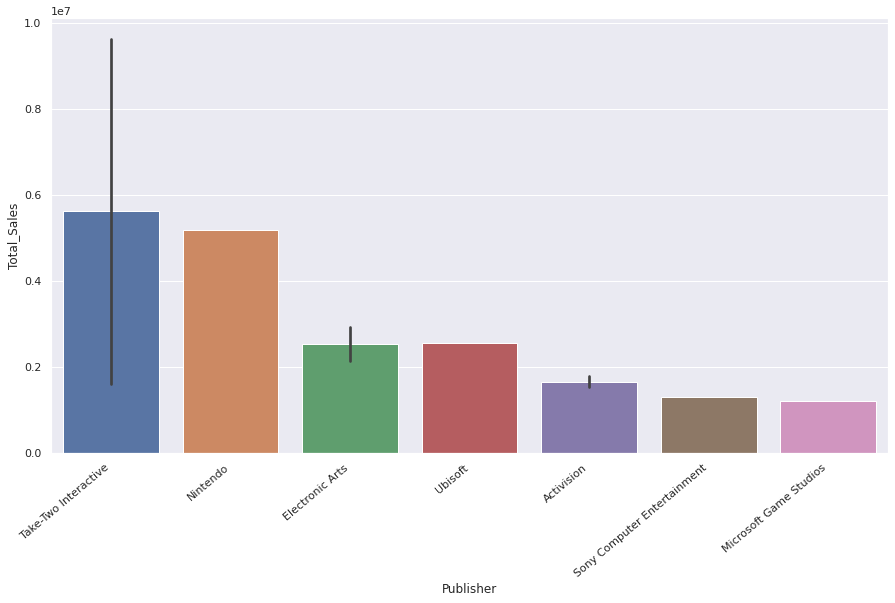

In [ ]:
q3_df3 = df[(df['Year'] > 2010)]
q3_df3[['Publisher', 'Total_Sales']].groupby(by=["Publisher"], dropna=True).agg(
{
    'Total_Sales': 'sum'
})
q3_df3.reset_index(inplace=True)
q3_df3.sort_values(by='Total_Sales', ascending=False, inplace=True)

q3_df3 = q3_df3.iloc[:10]

g = sns.barplot(
    x="Publisher", y="Total_Sales", data=q3_df3
)

g.set_xticklabels(g.get_xticklabels(), rotation=40, ha="right")

### 3.4. Name 관점

[Text(0, 0, 'Grand Theft Auto V'),
 Text(0, 0, 'Halo: Reach'),
 Text(0, 0, 'Mario Kart 64'),
 Text(0, 0, 'Pokemon X/Pokemon Y'),
 Text(0, 0, 'The Legend of Zelda: Ocarina of Time'),
 Text(0, 0, 'Pokemon FireRed/Pokemon LeafGreen'),
 Text(0, 0, 'Pok챕mon Yellow: Special Pikachu Edition'),
 Text(0, 0, 'FIFA 14'),
 Text(0, 0, 'Super Mario Bros. 3'),
 Text(0, 0, 'Super Mario 64')]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52309 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52309 missing from current font.
  font.set_text(s, 0, flags=flags)


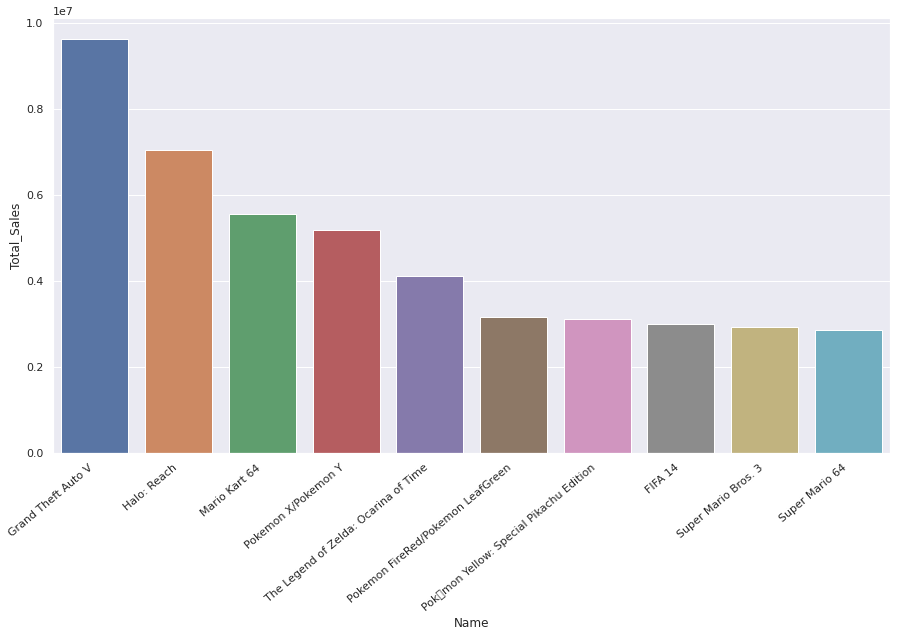

In [ ]:
q3_df4 = df[['Name', 'Total_Sales']].groupby(by=["Name"], dropna=True).agg(
{
    'Total_Sales': 'sum'
})
q3_df4.reset_index(inplace=True)
q3_df4.sort_values(by='Total_Sales', ascending=False, inplace=True)

q3_df4 = q3_df4.iloc[:10]

g = sns.barplot(
    x="Name", y="Total_Sales", data=q3_df4
)

g.set_xticklabels(g.get_xticklabels(), rotation=40, ha="right")

[Text(0, 0, 'Grand Theft Auto V'),
 Text(0, 0, 'Pokemon X/Pokemon Y'),
 Text(0, 0, 'FIFA 14'),
 Text(0, 0, "Assassin's Creed III"),
 Text(0, 0, 'Battlefield 3'),
 Text(0, 0, 'Call of Duty: Ghosts'),
 Text(0, 0, 'NBA 2K12'),
 Text(0, 0, 'Call of Duty: Advanced Warfare'),
 Text(0, 0, "Uncharted 4: A Thief's End"),
 Text(0, 0, 'Forza Motorsport 5')]

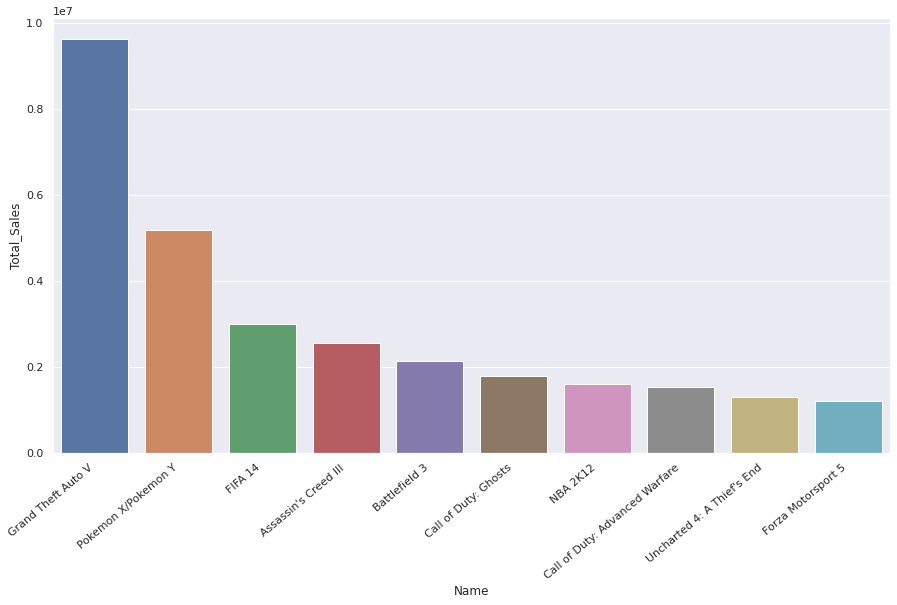

In [ ]:
q3_df4 = df[(df['Year'] > 2010)]

q3_df4 = q3_df4[['Name', 'Total_Sales']].groupby(by=["Name"], dropna=True).agg(
{
    'Total_Sales': 'sum'
})
q3_df4.reset_index(inplace=True)
q3_df4.sort_values(by='Total_Sales', ascending=False, inplace=True)

q3_df4 = q3_df4.iloc[:10]

g = sns.barplot(
    x="Name", y="Total_Sales", data=q3_df4
)

g.set_xticklabels(g.get_xticklabels(), rotation=40, ha="right")

## 과제 결론(다음 분기에 어떤 게임을 설계해야 할까)

#### 앞에서 실시한 3개의 작업을 통해 제가 내린 결론은 GTA5 같은 액션 장르와 매해 사랑을 받는 스포츠 장르, 최근 닌텐도회사 등에서 많이 출시하는 롤플레잉 장르의 게임들을 설계해야 한다는 결론을 도출했습니다. 
* 첫 번째로 액션장르를 선택한 이유는 2010년대 들어서 사랑을 받은 장르 데이터를 보면 1980년대부터 현재까지의 데이터와 마찬가지로 액션 장르가 압도적으로 높은 것을 확인할 수 있습니다. 또 테이크 투 회사의 액션게임인 GTA5의 출고량이 과거부터 현재까지의 데이터에서 압도적인 1위를 기록한 것을 통해 액션장르의 게임이 소비자로부터 얼마나 많은 사랑을 받았는지 우리는 알 수 있습니다. 이로인해 저희 회사도 액션장르 시장을 반드시 공략해야한다고 생각합니다. 
* 두 번째로 스포츠 장르를 고른 이유는 매년 장르데이터 비율을 알아본 그래프를 통해 알 수 있듯이 스포츠 장르는 변화하긴 하지만 많은 소비자들이 수요를 원했음을 확인하였습니다. 스포츠 매니아들을 공략하는 스포츠 게임을 개발해서 출시한다면 성공적인 수익을 얻을 수 있으리라 기대합니다. 
* 세 번째로 고른 롤플레잉 장르 게임 개발은 최근 게임회사별 출고량 비율을 시각화한 데이터를 통해 소비자들의 닌텐도 회사의 제품을 선호한다는 점, 총 출고량 데이터에서 포켓몬 게임이 2위를 기록한 점과 현재 영화 만화 게임 등을 여러 매체로 출시하는 미디어 믹스 현상이 많다는 것을 토대로 결정을 내렸습니다. 우리도 포켓몬, 마블, 웹툰과 같은 미디어 믹스 시장의 시대적인 트렌드에 맞는 롤플레잉 게임을 개발한다면 성공적인 분기 손익을 기록할 것이라 전망합니다. 